## Robot Data Preprocessing

This notebook takes the raw UR10-robot and Robotiq force/torque data and prepares them for machine learning.

In [49]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

file_path = '/home/ur10pc/Desktop/robot_data9/data/'
ur_data_file = 'ur_data.csv'
force_data_file = 'force_data.csv'

## Import Robotiq Force/Torque Data
This is the force/torque data from the robotiq sensor fitted to the UR10's end-effector. 
It was collected using the Robot Operating System (ROS) and ROSbags which were converted to csv.

In [50]:
robotiq_data = pd.read_csv(file_path + force_data_file)
robotiq_data.columns = ['robotiq_TS', 'Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz']
pd.set_option('display.precision', 5)
df1= pd.DataFrame(robotiq_data.iloc[:, 1:7])
display(df1)
robotiq_TS = pd.DataFrame(robotiq_data.iloc[:,0])

,Fx,Fy,Fz,Tx,Ty,Tz
0,0.790,-0.830,-0.080,0.041,0.209,0.051
1,0.830,-0.810,-0.040,0.038,0.212,0.051
2,0.830,-0.840,-0.050,0.038,0.209,0.052
3,0.690,-0.130,-0.090,-0.001,0.206,0.051
4,-0.050,-3.100,-0.720,0.331,0.087,0.018
...,...,...,...,...,...,...
24995,-0.430,1.330,2.950,-0.405,-0.240,-0.111
24996,-0.350,1.390,2.950,-0.404,-0.239,-0.108
24997,-0.360,1.290,2.940,-0.401,-0.240,-0.109
24998,-0.250,1.280,2.960,-0.407,-0.232,-0.110


## Make New Separate Force and Torque Dataframes 

In [51]:
force = pd.DataFrame(df1.iloc[:,0:3])
torque = pd.DataFrame(df1.iloc[:,3:6])

from IPython.display import display_html 

force_styler = force.head(5).style.set_table_attributes("style='display:inline'").set_caption('Force DF')
torque_styler = torque.head(5).style.set_table_attributes("style='display:inline'").set_caption('Torque DF')
display_html(force_styler._repr_html_()+torque_styler._repr_html_(), raw=True)

,Fx,Fy,Fz
0,0.78999,-0.83000,-0.08000
1,0.82999,-0.81000,-0.04000
2,0.82999,-0.84001,-0.05000
3,0.68999,-0.13000,-0.09000
4,-0.05000,-3.10001,-0.72000
,Tx,Ty,Tz
0,0.04100,0.20900,0.05100
1,0.03800,0.21200,0.05100
2,0.03800,0.20900,0.05200
3,-0.00100,0.20600,0.05100


## Vector Sum Calculations for Force and Torque
As it stands, the force and torque are both 3d vectors. Summing the vector components returns a single positive int that can be used as a target features. 

In [52]:
force_vector = pd.DataFrame(np.sqrt((force['Fx']**2)+(force['Fy']**2)+(force['Fz']**2)))
torque_vector = pd.DataFrame(np.sqrt((torque['Tx']**2)+(torque['Ty']**2)+(torque['Tz']**2)))
force_vector.columns =['Force Vec']
torque_vector.columns =['Torque Vec']

force_vector_styler = force_vector.head(5).style.set_table_attributes("style='display:inline'").set_caption('Force Vector')
torque_vector_styler = torque_vector.head(5).style.set_table_attributes("style='display:inline'").set_caption('Torque Vector')

display_html(force_vector_styler._repr_html_()+torque_vector_styler._repr_html_(), raw=True)


,Force Vec
0,1.14865
1,1.16042
2,1.18195
3,0.70787
4,3.18291
,Torque Vec
0,0.21900
1,0.22133
2,0.21870
3,0.21222


## Reduce The Magnitude of The ROS Timestamp 
The default ROS timestamp is expressed in nanoseconds. Dividing by x10^9 converts the timestamp to seconds which is much easier to compare timestamps from different dataframes, as the data frequency was set to 10Hz, there should be 10 datapoints with the same second denomination but differing tenths of seconds. This is what was used to calibrate the ROS topic throttle messages and the ROSbag sampling frequency. 

In [53]:
robotiq_TS2 = robotiq_TS.apply(lambda x: x/1000_000_000)
pd.options.display.float_format = '{:.3f}'.format
display(robotiq_TS2)

,robotiq_TS
0,1607963012.927
1,1607963013.038
2,1607963013.149
3,1607963013.260
4,1607963013.376
...,...
24995,1607961693.728
24996,1607961693.839
24997,1607961693.950
24998,1607961694.065


## Import The Robot Position, Velocity and Effort Data
The data contains a lot of unnecessary information plus, the header names are wrong and need correcting. 

In [54]:
ur_data = pd.read_csv(file_path + ur_data_file)

display(ur_data.head())

## Everything below is for nostalgia! 
# Remove unwanted datapoints that were braking the sync between dataframes. ## we dont need this anymore!!!!
# ur_data = ur_data.drop(ur_data.index[11047])
# ur_data = ur_data.drop(ur_data.index[14000])
# ur_data = ur_data.drop(ur_data.index[18006])
# ur_data = ur_data.drop(ur_data.index[20011])
# ur_data = ur_data.drop(ur_data.index[20046])
# ur_data = ur_data.drop(ur_data.index[70014])

# ur_data = ur_data.reset_index(drop=True)

,rosbagTimestamp,header,seq,stamp,secs,nsecs,frame_id,name,wrist_3_joint],position,velocity,effort
0,1607963012906694843,nan,2432757,nan,1607963012,906388861,'',"[shoulder_pan_joint, shoulder_lift_joint, elbo...","[0.8880992531776428, -0.920875374470846, 2.064...","[0.0, 0.0, -0.0, 0.0, 0.0, 0.0]","[-1.0711671113967896, -6.248474597930908, -1.6...",nan
1,1607963013018840587,nan,2432771,nan,1607963013,18458984,'',"[shoulder_pan_joint, shoulder_lift_joint, elbo...","[0.888087272644043, -0.9209230581866663, 2.064...","[0.0, 0.0, -0.0, 0.0, 0.0, 0.0]","[-1.1077882051467896, -6.188965320587158, -1.6...",nan
2,1607963013130707189,nan,2432785,nan,1607963013,130352957,'',"[shoulder_pan_joint, shoulder_lift_joint, elbo...","[0.8881351947784424, -0.920875374470846, 2.064...","[0.0, 0.0, -0.0, 0.0, 0.0, 0.0]","[-1.1032105684280396, -6.230164051055908, -1.5...",nan
3,1607963013242771752,nan,2432799,nan,1607963013,242404596,'',"[shoulder_pan_joint, shoulder_lift_joint, elbo...","[0.888087272644043, -0.9208992163287562, 2.064...","[0.0, 0.0, -0.0, 0.0, 0.0, 0.0]","[-1.0986329317092896, -6.211853504180908, -1.6...",nan
4,1607963013354818591,nan,2432813,nan,1607963013,354404097,'',"[shoulder_pan_joint, shoulder_lift_joint, elbo...","[0.889406681060791, -0.9204915205584925, 2.063...","[0.013307283632457256, 0.0006391586503013968, ...","[0.9246827363967896, -5.314636707305908, -1.92...",nan


## Format ROS Timestamp for Robot Data
This snippet is again, for comparing the timestamps between the robot and Robotiq data sets. 

In [55]:
ur_data_timestamp = ur_data['rosbagTimestamp']
ur_data_timestamp2 = ur_data_timestamp.apply(lambda x: x/1000_000_000)
pd.options.display.float_format = '{:.3f}'.format
bob = pd.concat([ur_data_timestamp2, robotiq_TS2], axis=1)
display(bob)


,rosbagTimestamp,robotiq_TS
0,1607963012.907,1607963012.927
1,1607963013.019,1607963013.038
2,1607963013.131,1607963013.149
3,1607963013.243,1607963013.260
4,1607963013.355,1607963013.376
...,...,...
24995,1607961693.693,1607961693.728
24996,1607961693.805,1607961693.839
24997,1607961693.917,1607961693.950
24998,1607961694.029,1607961694.065


## Parse and Expand The Robot Position Data
The robot position is lumped into a single column as a 6d vector. This snippet splits the vector into components-  'joint_0','joint_1','joint_2','joint_3', 'joint_4' and 'joint_5'.
In oder to split the vector, it needed converting into a string which then left unwanted commas which needed removing. 

In [56]:
ur_data2 = ur_data.iloc[:,8]
ur_data_timestamp = ur_data.iloc[:,0]
ur_data_timestamp = pd.DataFrame(ur_data_timestamp)
#display(ur_data_timestamp)
ur_data_joints_pos = pd.DataFrame(ur_data2.str.split().values.tolist())

ur_data_joints_pos.columns = ['joint_0','joint_1','joint_2','joint_3', 'joint_4','joint_5']
ur_data_joints_pos['joint_0'] =  ur_data_joints_pos['joint_0'].apply(lambda x: x.replace('[','').replace(',','')).astype(float)
ur_data_joints_pos['joint_1'] =  ur_data_joints_pos['joint_1'].apply(lambda x: x.replace(',','')).astype(float)
ur_data_joints_pos['joint_2'] =  ur_data_joints_pos['joint_2'].apply(lambda x: x.replace(',','')).astype(float)
ur_data_joints_pos['joint_3'] =  ur_data_joints_pos['joint_3'].apply(lambda x: x.replace(',','')).astype(float)
ur_data_joints_pos['joint_4'] =  ur_data_joints_pos['joint_4'].apply(lambda x: x.replace(',','')).astype(float)
ur_data_joints_pos['joint_5'] =  ur_data_joints_pos['joint_5'].apply(lambda x: x.replace(',','').replace(']','')).astype(float)


display(ur_data_joints_pos.head(5))

,joint_0,joint_1,joint_2,joint_3,joint_4,joint_5
0,0.888,-0.921,2.064,-2.715,4.710,2.263
1,0.888,-0.921,2.064,-2.715,4.710,2.263
2,0.888,-0.921,2.064,-2.715,4.710,2.263
3,0.888,-0.921,2.064,-2.715,4.710,2.263
4,0.889,-0.920,2.064,-2.714,4.710,2.268


#### Save a copy of the full joint positions data. This will be used to learn a kinematics model.

In [57]:
ur_data_joints_pos.to_csv(file_path + 'joints_data.csv', index=False)

## Parse and Expand the Robot Joint Effort Column
As with the joint position above, the joint effort was lumped into a single column as a 6d vector, which required the same treatment. 

In [58]:

ur_data_joint_effort = ur_data.iloc[:,10]
ur_data_joint_effort = pd.DataFrame(ur_data_joint_effort.str.split().values.tolist())

ur_data_joint_effort.columns = ['effot_joint_0','effot_joint_1','effot_joint_2','effot_joint_3', 'effot_joint_4','effot_joint_5']
ur_data_joint_effort['effot_joint_0'] =  ur_data_joint_effort['effot_joint_0'].apply(lambda x: x.replace('[','').replace(',','')).astype(float)
ur_data_joint_effort['effot_joint_1'] =  ur_data_joint_effort['effot_joint_1'].apply(lambda x: x.replace(',','')).astype(float)
ur_data_joint_effort['effot_joint_2'] =  ur_data_joint_effort['effot_joint_2'].apply(lambda x: x.replace(',','')).astype(float)
ur_data_joint_effort['effot_joint_3'] =  ur_data_joint_effort['effot_joint_3'].apply(lambda x: x.replace(',','')).astype(float)
ur_data_joint_effort['effot_joint_4'] =  ur_data_joint_effort['effot_joint_4'].apply(lambda x: x.replace(',','')).astype(float)
ur_data_joint_effort['effot_joint_5'] =  ur_data_joint_effort['effot_joint_5'].apply(lambda x: x.replace(',','').replace(']','')).astype(float)


display(ur_data_joint_effort.head(5))

,effot_joint_0,effot_joint_1,effot_joint_2,effot_joint_3,effot_joint_4,effot_joint_5
0,-1.071,-6.248,-1.605,-0.538,0.251,-0.029
1,-1.108,-6.189,-1.605,-0.520,0.247,-0.022
2,-1.103,-6.230,-1.596,-0.567,0.247,-0.031
3,-1.099,-6.212,-1.612,-0.489,0.247,-0.018
4,0.925,-5.315,-1.926,-0.554,-0.013,0.352


## Parse and Expand The Robot Joint Velocity Vector. 

In [59]:
ur_data_velocity0 = ur_data.iloc[:,9]

ur_data_velocity = pd.DataFrame(ur_data_velocity0.str.split().values.tolist())
ur_data_velocity.columns = ['vel_joint_0','vel_joint_1','vel_joint_2','vel_joint_3', 'vel_joint_4','vel_joint_5']
ur_data_velocity['vel_joint_0'] =  ur_data_velocity['vel_joint_0'].apply(lambda x: x.replace('[','').replace(',','')).astype(float)
ur_data_velocity['vel_joint_1'] =  ur_data_velocity['vel_joint_1'].apply(lambda x: x.replace(',','')).astype(float)
ur_data_velocity['vel_joint_2'] =  ur_data_velocity['vel_joint_2'].apply(lambda x: x.replace(',','')).astype(float)
ur_data_velocity['vel_joint_3'] =  ur_data_velocity['vel_joint_3'].apply(lambda x: x.replace(',','')).astype(float)
ur_data_velocity['vel_joint_4'] =  ur_data_velocity['vel_joint_4'].apply(lambda x: x.replace(',','')).astype(float)
ur_data_velocity['vel_joint_5'] =  ur_data_velocity['vel_joint_5'].apply(lambda x: x.replace(',','').replace(']','')).astype(float)

display(ur_data_velocity.head())

,vel_joint_0,vel_joint_1,vel_joint_2,vel_joint_3,vel_joint_4,vel_joint_5
0,0.000,0.000,-0.000,0.000,0.000,0.000
1,0.000,0.000,-0.000,0.000,0.000,0.000
2,0.000,0.000,-0.000,0.000,0.000,0.000
3,0.000,0.000,-0.000,0.000,0.000,0.000
4,0.013,0.001,0.004,-0.000,0.000,0.042


## Concatenate Features
After parsing and reconstructing the robot position, effort and velocity features, they can now be combined along with each other and with the force and torque dataframes. 

In [60]:
full_data = pd.concat([ur_data_timestamp2, df1, ur_data_joints_pos, ur_data_velocity, ur_data_joint_effort, force_vector, torque_vector], axis=1)

#print(df.iloc[:, 1].round(-1))
pd.options.display.float_format = '{:.3f}'.format
#pd.reset_option('^display.', silent=True)
#display(robotiq_data)

display(full_data.head(5))
# for i in range(6):
#     print(f'Vel Joint{i}')
#     print(ur_joint_data[f'vel_joint_{i}'].mean())
#     display(ur_joint_data[f'vel_joint_{i}'].describe())

,rosbagTimestamp,Fx,Fy,Fz,Tx,Ty,Tz,joint_0,joint_1,joint_2,...,vel_joint_4,vel_joint_5,effot_joint_0,effot_joint_1,effot_joint_2,effot_joint_3,effot_joint_4,effot_joint_5,Force Vec,Torque Vec
0,1607963012.907,0.790,-0.830,-0.080,0.041,0.209,0.051,0.888,-0.921,2.064,...,0.000,0.000,-1.071,-6.248,-1.605,-0.538,0.251,-0.029,1.149,0.219
1,1607963013.019,0.830,-0.810,-0.040,0.038,0.212,0.051,0.888,-0.921,2.064,...,0.000,0.000,-1.108,-6.189,-1.605,-0.520,0.247,-0.022,1.160,0.221
2,1607963013.131,0.830,-0.840,-0.050,0.038,0.209,0.052,0.888,-0.921,2.064,...,0.000,0.000,-1.103,-6.230,-1.596,-0.567,0.247,-0.031,1.182,0.219
3,1607963013.243,0.690,-0.130,-0.090,-0.001,0.206,0.051,0.888,-0.921,2.064,...,0.000,0.000,-1.099,-6.212,-1.612,-0.489,0.247,-0.018,0.708,0.212
4,1607963013.355,-0.050,-3.100,-0.720,0.331,0.087,0.018,0.889,-0.920,2.064,...,0.000,0.042,0.925,-5.315,-1.926,-0.554,-0.013,0.352,3.183,0.343


In [61]:
full_data.to_csv(file_path + 'full_data_less_cart.csv', index=False)

## Correlation Algorithm and Heat Map

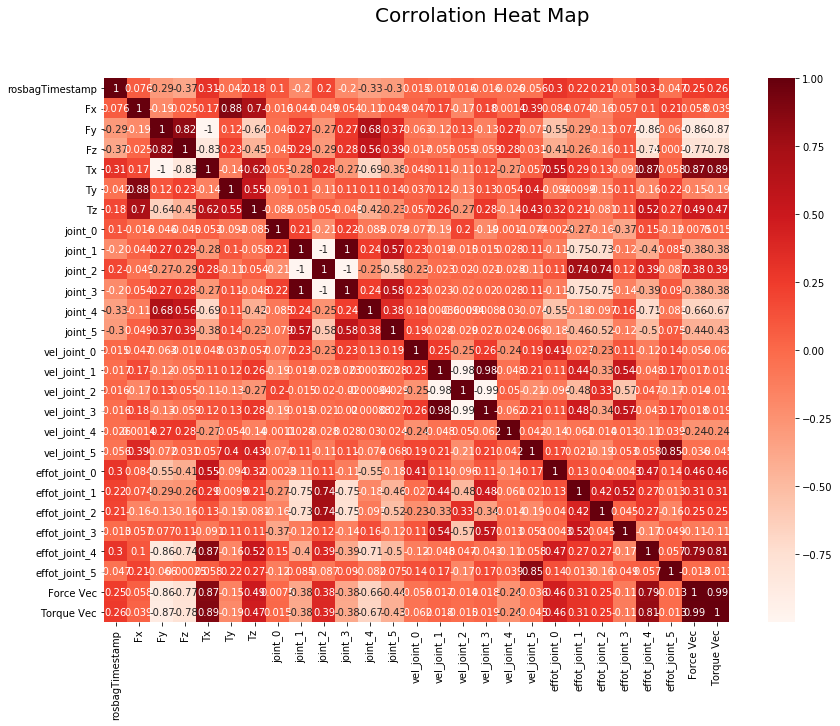

In [62]:
plt.figure(figsize=(14,10))
x = full_data 

cor = x.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

plt.suptitle('Corrolation Heat Map', fontsize=20)

plt.show()

## Remove Unnecessary Velocity Features
Joint 2 appears to correlate largely with joints 1 and 3 for position and velocity, so these features will be removed to simplify the model. Torque correlates highly with force, therefore, torque will also be removed. 

In [ ]:
ur_data_velocity = ur_data_velocity.drop('vel_joint_1', 1)
ur_data_velocity = ur_data_velocity.drop('vel_joint_3', 1)


display(ur_data_velocity.head(5))

## Remove Unnecessary Position Features 

In [ ]:
ur_data_joints_pos = ur_data_joints_pos.astype(np.float64)
ur_data_joints_pos = ur_data_joints_pos.drop('joint_1', 1)
ur_data_joints_pos = ur_data_joints_pos.drop('joint_3', 1)

display(ur_data_joints_pos)

## Concatenate Selected Features

In [ ]:
ur_joint_data = pd.concat([force, ur_data_joints_pos, force_vector], axis=1)# ur_data_joint_effort, ur_data_velocity], axis=1)

#print(df.iloc[:, 1].round(-1))
pd.options.display.float_format = '{:.3f}'.format
#pd.reset_option('^display.', silent=True)
#display(robotiq_data)

display(ur_joint_data.head(5))

In [ ]:
display(ur_joint_data.tail(5))

### Save features to .csv

In [ ]:
ur_joint_data.to_csv(file_path + '4_joints_3_force_1_forceVec.csv', index=False)

## Data Shuffling
Shuffling the data is important because it removes correlations in the data series. Correlations occur in time series data because each data point is very similar to the last few data points. When feeding your data to a learning algorithm, if you do not shuffle your data, the model will become bias to the last batch of data which is highly correlated and forget earlier parameters set using earlier data.

In [ ]:
shuffle0 = ur_joint_data.iloc[np.random.permutation(len(ur_joint_data))]
shuffle = shuffle0.reset_index(drop=True)
display(shuffle.head())
print(np.shape(shuffle))

### Save a sample of the data for normalising future data points

data_sample = shuffle.head(20)
data_sample.to_csv("/home/ur10pc/Desktop/robot_data2/80k_data/data_sample.csv", index=False)
display(data_sample.head(50))

## PolynomialFeatures - If Needed Later
When there are known nonlinearities hiding in the data which have an effect on the output, adding polynomial features can help the model learn these nonlinearities which give more accurate results.

## Code Used To Generate Synthetic Data. This is Unlikely To Be Needed

## Normalisation 
This snippet pre-processes the data by scaling the features. This has the effect of reducing bias in the input features by making them all of the same oder of magnitude which improves the model.

In [ ]:
from sklearn.preprocessing import StandardScaler
data = shuffle.drop('Force Vec', axis=1)
scaler = StandardScaler()
scaler.fit(data)

#print(scaler.mean_)

data2 = scaler.transform(data)
data2 = pd.DataFrame(data2)
data2.columns= data.columns

#print(scaler.transform([[2, 2]]))
data2 = pd.DataFrame(data2)
display(data2.head())

## Concat Normalised Feature Data with Force Target

In [ ]:
combined_normalised_data = pd.concat([data2, shuffle['Force Vec']], axis=1)
display(combined_normalised_data)
print(np.shape(combined_normalised_data))

### Save data to .csv

In [ ]:
shuffle.to_csv("/home/ur10pc/Desktop/robot_data2/80k_data/trimmed_joints_force_data.csv", index=False)